# Facebook messenger statistics
Paste the path to a directory of a chat you'd like to analyze. It should contain 1 or more json files with names like 'message_1.json', 'message_2.json', etc.<br> The path should be enclosed with single or double quotes, and there should be an 'r' in front of the quotes, like this:<br>
PATH = _r'C:\mypath\mychat'<br>_
When that's ready you can click on Cell in the menu above and select 'Run All'

In [1]:
%matplotlib inline
import stats_pandas as stats
import pandas as pd
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

init_notebook_mode(connected=True)
 
PATH = r'D:\facebook 08.06.2020\wypakowane\inbox\gadzetyinspektora_9ZWCplP1iw'
    
chat = stats.load_from_path(PATH)

## General chat statistics

In [2]:
msg_stats_dict = stats.get_msg_stats(chat)
msg_stats = pd.DataFrame.from_dict(msg_stats_dict, columns = ['Total msgs sent', 'Avg msg length', 'Total chars sent'], orient = 'index')


col = 'Total msgs sent'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, text = col, labels = {'x': 'Sender'}, color = col,
           title = 'Total messages sent', color_continuous_scale = px.colors.sequential.RdPu)
f.update(layout_coloraxis_showscale=False)
#f.update_traces(textposition = 'outside')
f

In [3]:
col = 'Avg msg length'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, labels = {'x': 'Sender'}, text = col ,color = col,
           title = 'Average characters per message', color_continuous_scale = px.colors.sequential.Sunset)
f.update_traces(texttemplate='%{text:.1f}')
f.update(layout_coloraxis_showscale=False)
f

In [4]:
col = 'Total chars sent'
df2 = msg_stats.sort_values(by = col, ascending = False)
f = px.bar(df2, y = col, x = df2.index, labels = {'x': 'Sender'}, color = col, text = col,
           title = 'Total characters sent', color_continuous_scale = px.colors.sequential.PuBu)
f.update_traces(textposition = 'outside')
f.update(layout_coloraxis_showscale=False)
f

## Does average message length correlate with the number of messages sent?

In [5]:
fig = px.scatter(msg_stats, y = 'Avg msg length', x = 'Total msgs sent', trendline = 'ols', trendline_color_override = 'red')
fig.show()
cor = msg_stats.corr().iloc[0,1]
cor = msg_stats.corr().loc['Total msgs sent', 'Avg msg length']
print('The correlation is', cor)

The correlation is 0.47036359496858354


## Top 20 words most frequently used by each chat participant
You can change the minimal word lengths below

In [6]:
#change excluded words here:  excluded = ['example', 'example2']
excluded = ['example', 'example2']


#### change min_word_length here
min_word_length = 6 


word_counts = stats.get_word_counts(chat, filter_participants_names = True, min_len = min_word_length, exclude_words = excluded)

In [7]:
plt_titles = [f'{sender} - min. word length = {min_word_length}' for sender in word_counts]
fig = make_subplots(
    rows=len(word_counts),
    cols=1,
    subplot_titles=plt_titles,
)
for i,sender in enumerate(word_counts):
    df = pd.DataFrame(word_counts[sender].items())[0:20]
    df.columns = ['word', 'count']
    f = px.bar(df, y = 'count', x = 'word', color = df.index)
    fig.add_trace(f.data[0], row = i + 1, col = 1)
fig.update_layout(height=len(word_counts) * 350, width=900)
fig.update(layout_coloraxis_showscale=False)
fig.show()

## How often has _word1_ been used?
Set _word1_ below - it can be a single word, but also be a list of words.
If regex=True is specified, word1 can also be a re str pattern, or a list of re str patterns.

In [8]:
word_counts = stats.get_word_counts(chat, False, None, 1) #get unfiltered word_counts


In [9]:



word1 = ['prosze', 'proszę'] ## set word1 here



#w1_coeffs = stats.get_kurwa_coefficients(word_counts_unfiltered, )
w1_coeffs = stats.word_usage_coefficients(word1, word_counts, msg_stats_dict, regex = False)
w1_coeffs = {k:v * 100 for k,v in sorted(w1_coeffs.items(), key = lambda item: item[1], reverse = True)}
w1_df = pd.DataFrame(w1_coeffs.items(), columns = ['Sender', f'{word1} per 100 msgs'])
fig = px.bar(w1_df, y = f'{word1} per 100 msgs', x = 'Sender')
fig.show()

## How often has every (polish) swear word been used?

In [10]:
pcoeffs = stats.get_profanity_coefficients(word_counts, msg_stats_dict, ignore_kurwas = False)

pcoeffs = {k:v * 100 for k,v  in sorted(pcoeffs.items(), key = lambda item: item[1], reverse = True)}
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
fig = px.bar(df, y = 'Profanity per 100 msgs', x = 'Sender')
fig.show()
df

,Sender,Profanity per 100 msgs
0,Kamil Bączek,8.510638
1,Maciek Górski,8.389824
2,Paweł Budniak,7.960684
3,Bartek Królak,7.777638
4,Filip Perzanowski,6.518991
5,Daniel Sypuła,6.489617
6,Jakub Gąsior,5.894119
7,Piotrek Jaworski,4.437387
8,Krzysiek Iwaniuk,3.270142
9,Marta Marcia Wisniewska,0.000000


## Correlation of _word1_ usage with (polish) swear word usage

In [11]:
df = pd.DataFrame(pcoeffs.items(), columns = ['Sender', 'Profanity per 100 msgs'])
df = df.merge(w1_df, how = 'inner')
cor = df.corr().iloc[0,1]
fig = px.scatter(df,y = 'Profanity per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is 0.5048714643076916


## Correlation of _word1_ (set above) usage with _word2_ (set below) usage

In [12]:

word2 = ['dziękuję', 'dziekuje'] # set word2 here



if word1 == word2:
    print('word 2 has to be different from word1')
w2_coeffs = stats.word_usage_coefficients(word2, word_counts, msg_stats_dict, regex = False)
w2_coeffs = {k:v * 100 for k,v in w2_coeffs.items()}
w2_df = pd.DataFrame(w2_coeffs.items(), columns = ['Sender', f'{word2} per 100 msgs'])

nat_join = w2_df.merge(w1_df, how = 'inner')
cor = nat_join.corr().iloc[0,1]
fig = px.scatter(nat_join,y = f'{word2} per 100 msgs', x = f'{word1} per 100 msgs', trendline="ols", trendline_color_override = 'pink')
fig.show()
print('The correlation is', cor)

The correlation is 0.8142594298205716


## Types of messages sent

In [13]:
import math

# Set include_txt = True if the basic text message type should be included in the pie charts
msg_types = stats.get_msg_types(chat, include_txt = False)
ceiling = math.ceil(len(msg_types)/2)

fig = make_subplots(
    rows=ceiling,
    cols=2,
    subplot_titles=tuple(msg_types.keys()),
    specs =[[{'type':'domain'}]*2]*ceiling
)

for i,sender in enumerate(msg_types):
    mydf = pd.DataFrame.from_dict(msg_types[sender], orient = 'index', columns = ['count'])
    f = px.pie(mydf, values = 'count', names = mydf.index)
    fig.add_trace(f.data[0], row = math.ceil((i+1)/2), col = (i)%2+1)
fig.update_layout(height=500 * ceiling, width=900)
fig.show()

In [14]:
pd.DataFrame(stats.get_msg_types(chat, include_txt = True))

,Paweł Budniak,Jakub Gąsior,Filip Perzanowski,Piotrek Jaworski,Maciek Górski,Bartek Królak,Daniel Sypuła,Krzysiek Iwaniuk,Marta Marcia Wisniewska,Kamil Bączek
photos,670,679.0,1295,370,3454,269.0,422.0,165,1.0,23.0
videos,7,38.0,187,19,583,17.0,48.0,21,1.0,NaN
audio_files,1,7.0,37,1,135,NaN,5.0,2,NaN,NaN
gifs,5,56.0,66,1,116,NaN,NaN,4,NaN,NaN
files,2,NaN,1,4,13,NaN,NaN,1,NaN,NaN
sticker,12,66.0,110,36,104,6.0,3.0,75,NaN,16.0
share,98,97.0,112,34,345,14.0,34.0,32,NaN,5.0
txt,12602,14154.0,31516,11171,35797,7642.0,9539.0,1851,5.0,662.0


## Messages over time

In [15]:
dates = stats.groupby_date(chat, 'M')

f = px.line(dates, y = dates, x = dates.index, labels = {'y': 'Message count', 'x': 'Date'})
f.update_xaxes(nticks = 20)
f.show()

## Messages by time intervals

In [16]:
intervals = ['Y', 'M', 'W', 'H']
fullnames = {'Y': 'Year', 'M': 'Month', 'W': 'Weekday', 'H': 'Hour'}

plt_titles = [fullnames[i] for i in intervals]
fig = make_subplots(
    rows=len(intervals),
    cols=1,
    subplot_titles=plt_titles,
)

for i,interval in enumerate(intervals):
    series = stats.groupby_time(chat, interval, interval_names = True)
    
    f = px.bar(series, x = series.index, y = series, labels = {'x': fullnames[interval], 'y': 'Message count'})
    fig.add_trace(f.data[0], row = i + 1, col = 1)
fig.update_layout(height=len(intervals) * 500, bargap = 0.4)
#series = stats.groupby_time(chat, 'M', interval_names = True)
#px.bar(series, x = series.index, y = series, labels = {'x': fullnames[interval], 'y': 'Message count'})

## Total reactions used in the chat

In [17]:
total_reacts = pd.Series(stats.total_reacts(chat)).sort_values(ascending = False)
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=('Total reactions flat', 'Total reactions percentages'),
    #specs =[[, {'type':'domain'}]]
    specs = [[{'type': 'bar'}, {'type':'domain'}]]
)
f1 = px.bar(x=total_reacts.index, y=total_reacts)
f2 = px.pie(values = total_reacts, names = total_reacts.index)
f2.update_traces(textposition='inside', textinfo='percent+label')
fig.add_trace(f1.data[0], row = 1, col = 1) 
fig.add_trace(f2.data[0], row = 1, col = 2) 
fig.show()

## Reactions used by participant
Seaborn/matplotlib can't display emojis on labels, so for pretty emoji graphs try the plotly notebook version

In [18]:
used, received = stats.reaction_stats(chat)
used

,😮,👍,😢,👎,😆,😠,😍,❤,total,most_used
Paweł Budniak,85.0,158.0,38.0,53.0,46.0,29.0,39.0,6.0,454.0,👍
Jakub Gąsior,189.0,238.0,93.0,77.0,48.0,31.0,114.0,15.0,805.0,👍
Filip Perzanowski,60.0,159.0,59.0,76.0,82.0,35.0,92.0,5.0,568.0,👍
Piotrek Jaworski,58.0,136.0,83.0,46.0,71.0,17.0,128.0,19.0,558.0,👍
Maciek Górski,20.0,164.0,28.0,120.0,18.0,24.0,139.0,133.0,646.0,👍
Bartek Królak,55.0,77.0,22.0,12.0,110.0,14.0,60.0,11.0,361.0,😆
Daniel Sypuła,90.0,79.0,56.0,9.0,138.0,14.0,71.0,6.0,463.0,😆
Krzysiek Iwaniuk,4.0,26.0,8.0,2.0,20.0,1.0,23.0,0.0,84.0,👍
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,😮
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,😮


## Reactions received by participant

In [19]:
received

,😠,😮,😆,❤,😢,👍,👎,😍,total,most_received
Paweł Budniak,33.0,73.0,115.0,15.0,32.0,170.0,90.0,65.0,593.0,👍
Jakub Gąsior,26.0,57.0,86.0,13.0,71.0,193.0,41.0,147.0,634.0,👍
Filip Perzanowski,29.0,140.0,66.0,10.0,100.0,195.0,72.0,131.0,743.0,👍
Piotrek Jaworski,14.0,53.0,40.0,10.0,25.0,121.0,57.0,44.0,364.0,👍
Maciek Górski,48.0,137.0,173.0,140.0,112.0,240.0,67.0,179.0,1096.0,👍
Bartek Królak,3.0,44.0,23.0,6.0,12.0,34.0,22.0,37.0,181.0,😮
Daniel Sypuła,10.0,47.0,26.0,1.0,33.0,78.0,43.0,55.0,293.0,👍
Krzysiek Iwaniuk,2.0,10.0,4.0,0.0,2.0,6.0,3.0,8.0,35.0,😮
Marta Marcia Wisniewska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,😠
Kamil Bączek,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,😠


## Ratio of each reaction received to total messages sent by each person

In [20]:
percents = stats.react_percents(received, msg_stats_dict)
percents

,😠,😮,😆,❤,😢,👍,👎,😍,total,most_received
Paweł Budniak,0.25%,0.55%,0.86%,0.11%,0.24%,1.28%,0.68%,0.49%,4.45%,👍
Jakub Gąsior,0.17%,0.38%,0.57%,0.09%,0.47%,1.29%,0.27%,0.98%,4.23%,👍
Filip Perzanowski,0.09%,0.42%,0.20%,0.03%,0.30%,0.59%,0.22%,0.39%,2.24%,👍
Piotrek Jaworski,0.12%,0.45%,0.34%,0.09%,0.21%,1.04%,0.49%,0.38%,3.12%,👍
Maciek Górski,0.12%,0.34%,0.43%,0.35%,0.28%,0.60%,0.17%,0.45%,2.74%,👍
Bartek Królak,0.04%,0.55%,0.29%,0.08%,0.15%,0.43%,0.28%,0.47%,2.28%,😮
Daniel Sypuła,0.10%,0.47%,0.26%,0.01%,0.33%,0.78%,0.43%,0.55%,2.93%,👍
Krzysiek Iwaniuk,0.09%,0.47%,0.19%,0.00%,0.09%,0.28%,0.14%,0.38%,1.66%,😮
Marta Marcia Wisniewska,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,😠
Kamil Bączek,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,😠


## People who receive the most reactions

In [21]:
titles = [ ('funniest', '😆'), ('most hated','👎'), ('most infuriating', '😠'),
           ('most beloved', '😍'), ('most shocking', '😮'), ('saddest', '😢'), ('most liked', '👍'), ('beloved v3', '💗'), ('beloved v2', '❤')]

for title, emoji in titles:
    stats.most_reactions(received, title, emoji, percent = False)

The funniest person is Maciek Górski: 173.0 of his messages received '😆', 2nd place: Paweł Budniak (115.0)

The most hated person is Paweł Budniak: 90.0 of his messages received '👎', 2nd place: Filip Perzanowski (72.0)

The most infuriating person is Maciek Górski: 48.0 of his messages received '😠', 2nd place: Paweł Budniak (33.0)

The most beloved person is Maciek Górski: 179.0 of his messages received '😍', 2nd place: Jakub Gąsior (147.0)

The most shocking person is Filip Perzanowski: 140.0 of his messages received '😮', 2nd place: Maciek Górski (137.0)

The saddest person is Maciek Górski: 112.0 of his messages received '😢', 2nd place: Filip Perzanowski (100.0)

The most liked person is Maciek Górski: 240.0 of his messages received '👍', 2nd place: Filip Perzanowski (195.0)

The beloved v2 person is Maciek Górski: 140.0 of his messages received '❤', 2nd place: Paweł Budniak (15.0)



## People who receive the most reactions relative to the number of messages they send

In [22]:
for title, emoji in titles:
    stats.most_reactions(percents, title, emoji, percent = True)

The funniest person is Paweł Budniak: 0.86% of his messages received '😆', 2nd place: Jakub Gąsior (0.57%)

The most hated person is Paweł Budniak: 0.68% of his messages received '👎', 2nd place: Piotrek Jaworski (0.49%)

The most infuriating person is Paweł Budniak: 0.25% of his messages received '😠', 2nd place: Jakub Gąsior (0.17%)

The most beloved person is Jakub Gąsior: 0.98% of his messages received '😍', 2nd place: Daniel Sypuła (0.55%)

The most shocking person is Paweł Budniak: 0.55% of his messages received '😮', 2nd place: Bartek Królak (0.55%)

The saddest person is Jakub Gąsior: 0.47% of his messages received '😢', 2nd place: Daniel Sypuła (0.33%)

The most liked person is Jakub Gąsior: 1.29% of his messages received '👍', 2nd place: Paweł Budniak (1.28%)

The beloved v2 person is Maciek Górski: 0.35% of his messages received '❤', 2nd place: Paweł Budniak (0.11%)



## Messages that received the biggest number of each reaction

In [23]:
stats.print_reaction_records(chat)


 Jakub Gąsior : 👍
Stop usuwaniu wiadomości

 Piotrek Jaworski : 👎
Chce ktoś na pójść na jakieś wpierdalanie?

 Paweł Budniak : 😆
<media>

 Maciek Górski : ❤
<media>

 Jakub Gąsior : 😍
<media>

 Paweł Budniak : 😮
Bruno Mars tak naprawde nie jest z Marsa

 Paweł Budniak : 😠
i rzezimieszki z kfc nie przywiozly mi frytek do zamowienia

 Daniel Sypuła : 😢
:(


## Top *n* record-holders of reactions recevied with more details and *m* adjacent messages for context

In [24]:
stats.emojis.keys()

dict_keys(['LIKE_EMOJI', 'DISLIKE_EMOJI', 'LAUGHING_EMOJI', 'HEART_EMOJI', 'HEART_EYES_EMOJI', 'SHOCKED_EMOJI', 'ANGRY_EMOJI', 'SAD_EMOJI', 'HEART_EMOJI_2'])

	 sender: Maciek Górski  2019-08-22 15:58:52.143000
	Generic
	 sender: Maciek Górski  2019-08-22 15:58:54.027000
	content:  xD 

👍: 5,  sender: Jakub Gąsior  2019-08-22 16:04:57.438000
content:  Stop usuwaniu wiadomości 

	 sender: Daniel Sypuła  2019-08-22 17:34:47.290000
	content:  chce ktos giere? 

	 sender: Maciek Górski  2019-08-22 17:35:52.425000
	content:  kyrwa 



	 sender: Maciek Górski  2019-01-21 18:57:07.411000
	

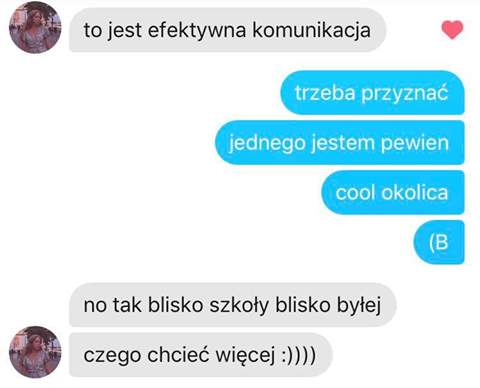

	 sender: Maciek Górski  2019-01-21 18:57:15.591000
	content:  tu się zaczęło 

👍: 5,  sender: Maciek Górski  2019-01-21 18:57:50.615000
content:  to takie smutne mozemy dostać 6lajkow? 

	 sender: Piotrek Jaworski  2019-01-21 19:16:39.456000
	content:  Dawaj duży odpal streama 

	 sender: Filip Perzanowski  2019-01-21 19:18:37.859000
	content:  Lol Maciek nie zepsułeś relacji 



	 sender: Paweł Budniak  2020-06-07 20:00:08.644000
	content:  przykre ze maciek nigdy nie spelnil swoich marzen 

	 sender: Paweł Budniak  2020-06-07 20:00:11.379000
	content:  o lapkach w gure 

👍: 4,  sender: Jakub Gąsior  2020-06-07 20:01:39.096000
content:  Kto nie idzie jutro do szkoły łapka w górę 

	 sender: Paweł Budniak  2020-06-07 20:06:39.854000
	content:  a na grupie ursynowskiej to chyba nie wiedz ze mozna dawac reakcje 

	 sender: Paweł Budniak  2020-06-07 20:06:43.960000
	content:  wszystkie wiadomosci maja max 2 





In [25]:
n = 3
m = 2
reaction_emoji = stats.emojis['LIKE_EMOJI'] # pick react type from keys displayed above

stats.most_reacted_msgs(chat, PATH, reaction_emoji, how_many = n, context = m)